In [36]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import CCA
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt

In [4]:
#11/5: cca is unsup. for expert: fit in X_expert, X_other instead of y



#10/29. do PCA instead of CCA without expert user. should take same inputs. figure out what structure needed to effectively run PCA
##### try LDA or SVC instead of KNN 





#10/22
#do fft on data prior to working with it
#fft: time to freq
#ifft: freq to time
#where they have EMG, it should be each gesture indiv. pull in the data as the dataframe with each column
#look at kai's github for breaking down pickle into gestures

#check the directory structure of momona's code

#time data going in the moments and time converted to freq should have the same moments.

In [5]:
stand_path = 'C:\\Users\\User\\Downloads\\Momona Data\\NEWmetadata_EMG_standardized_allusers.pkl'
pers_path = 'C:\\Users\\User\\Downloads\\Momona Data\\NEWmetadata_EMG_userdef_allusers.pkl'
kai_path = 'C:\\Users\\User\\Downloads\\Momona Data\\$BStand_EMG_df.pkl'

# Open the file in binary mode and load the data
with open(pers_path, 'rb') as file:
    EMG_pers = pickle.load(file)
    
with open(stand_path, 'rb') as file:
    EMG_stand = pickle.load(file)
    
#kai_stand= pd.read_pickle(kai_path)
# Now 'data' contains the deserialized Python object
print(EMG_stand.shape)
print(EMG_pers.shape)

(71360, 19)
(99200, 19)


# Feature Engineering

In [6]:
def zero_order(df_freq):
    zero_order_moments_log = []
    zero_order_moments_raw = []

    for sensor in df_freq.columns:
        # Extract the frequency domain data for the sensor (column of the dataframe)
        time_data = df_freq[sensor].values
        
        # Step 1: Square the signal (power) at each frequency
        signal_squared = np.abs(time_data) ** 2
        
        # Step 2: Integrate (sum) the squared values to get the total power
        total_power = np.sum(signal_squared)
        
        # Step 3: Take the logarithm of the total power
        log_total_power = np.log(total_power)
        
        # Store the result in the dictionary
        zero_order_moments_log.append(log_total_power)
        zero_order_moments_raw.append(total_power)
        
    return zero_order_moments_log, zero_order_moments_raw


In [7]:
def first_order(df_freq, zero_order_raw):
    # Initialize lists to store the results for each sensor
    first_order_moments_log = []
    first_order_moments_raw = []
    
    for i,sensor in enumerate(df_freq.columns):
        # Extract the frequency domain data for the sensor (column of the dataframe)
        time_data = df_freq[sensor].values
        
        # Step 1: Take first derivative
        first_deriv = np.gradient(time_data)
        
        # Step 2: Square the signal (power) at each frequency of the first deriv
        signal_squared = np.abs(first_deriv) ** 2
        
        # Step 3: Integrate (sum) the squared values to get the total power
        total_power = np.sum(signal_squared)
        
        # Step 4: Take the logarithm of the total power
        log_total_power = np.log(total_power / (zero_order_raw[i]**2))
        
        # Store the results in the lists
        first_order_moments_log.append(log_total_power)
        first_order_moments_raw.append(total_power)

    # Convert lists to numpy arrays for consistency
    first_order_moments_log = np.array(first_order_moments_log)
    first_order_moments_raw = np.array(first_order_moments_raw)
    
    return first_order_moments_log, first_order_moments_raw


In [8]:
def second_order(df_freq, zero_order_raw):
    second_order_log = []
    second_order_raw = []

    for i, sensor in enumerate(df_freq.columns):
        # Extract the time domain data for the sensor (column of the dataframe)
        time_data = df_freq[sensor].values
        
        # Step 1: Take first derivative
        first_deriv = np.gradient(time_data)
        
        #Step 2: take second derivative
        second_deriv = np.gradient(first_deriv)
        
        # Step 3: Square the signal (power) at each frequency of the first deriv
        signal_squared = np.abs(second_deriv) ** 2
        
        # Step 4: Integrate (sum) the squared values to get the total power
        total_power = np.sum(signal_squared)
        
        # Step 4: Take the logarithm of the total power
        log_total_power = np.log(total_power/(zero_order_raw[i]**4))
        
        # Store the result in the dictionary
        second_order_log.append(log_total_power)
        second_order_raw.append(total_power)

    
    return second_order_log, second_order_raw


In [9]:
#working version of third_order that has precautions so no neg values inside log
def third_order(second_order_raw, first_order_raw, zero_order_raw):
    second_order_raw = np.array(second_order_raw)
    first_order_raw = np.array(first_order_raw)
    zero_order_raw = np.array(zero_order_raw)
    
    # Step 1: Compute the square roots (ensure no negative values before sqrt)
    sqrt_first_diff = np.sqrt(np.maximum(zero_order_raw - first_order_raw, 1e-10))  # Handle small or negative values
    sqrt_second_diff = np.sqrt(np.maximum(zero_order_raw - second_order_raw, 1e-10))  # Handle small or negative values
    
    # Step 2: Perform the dot product (ensure no division by zero by adding a small constant)
    dot_product = np.dot(sqrt_first_diff, sqrt_second_diff)
    dot_product = max(dot_product, 1e-10)  # Avoid division by zero or extremely small numbers
    
    # Step 3: Compute the sparseness ratio (ensure the result is positive)
    sparseness = zero_order_raw / dot_product
    
    # Step 4: Logarithm of the sparseness (ensure no negative or zero values inside the log)
    # We use np.maximum to ensure all values are at least 1e-10 to avoid taking log of non-positive values.
    safe_sparseness = np.maximum(sparseness, 1e-10)
    
    #print("Safe sparseness:", safe_sparseness)
    
    # Step 5: Apply the logarithm for third-order moments
    third_order_moments_log = np.log(safe_sparseness)
    
    return third_order_moments_log


In [10]:
def fourth_order(df_freq, zero_order_raw, first_order_raw, second_order_raw):
    # Initialize a list to store the fourth-order moments log for each sensor
    fourth_order_moments_logs = []
    
    for i,sensor in enumerate(df_freq.columns):
        # Extract the time domain data for the sensor (column of the dataframe)
        time_data = df_freq[sensor].values
        
        # Step 1: Take first derivative
        first_deriv = np.gradient(time_data)
        
        # Step 2: Absolute value of the signal (power) at each frequency of the first derivative
        signal_abs = np.abs(first_deriv)
        
        # Step 3: Integrate (sum) the absolute values to get the total power
        total_power = np.sum(signal_abs)
        
        # Step 4: Compute the fourth-order moments log for this sensor
        moment_log = np.log(np.sqrt((first_order_raw[i]**2) / 
                           (zero_order_raw[i] * second_order_raw[i])) / total_power)
        
        # Store the result in the list
        fourth_order_moments_logs.append(moment_log)
    
    # Convert list to numpy array for consistency
    fourth_order_moments_logs = np.array(fourth_order_moments_logs)
    
    return fourth_order_moments_logs


In [11]:
def create_feature_vectors(group):
    result_vector = []
    #can only run features on EMG columns
    emg_columns = [col for col in group.columns if col.startswith('EMG')]
    
    for emg_col in emg_columns:
        data = group[[emg_col]] #run on EMG columns. convert to df with single column to run with all the features
        
        #zero-order
        zero_order_log, zero_order_raw = zero_order(data)
        result_vector.append(zero_order_log)
        
        #first-order
        first_order_log, first_order_raw = first_order(data, zero_order_raw)
        result_vector.append(first_order_log)
        
        #second-order
        second_order_log, second_order_raw = second_order(data, zero_order_raw)
        result_vector.append(second_order_log)
        
        #third-order
        third_order_log = third_order(second_order_raw, first_order_raw, zero_order_raw)
        result_vector.append(third_order_log)
        
        #fourth-order
        fourth_order_log = fourth_order(data, zero_order_raw, first_order_raw, second_order_raw)
        result_vector.append(fourth_order_log)
        
    return pd.DataFrame({
        'Participant': [group['Participant'].iloc[0]],
        'Gesture_ID': [group['Gesture_ID'].iloc[0]],
        'Gesture_Num': [group['Gesture_Num'].iloc[0]],
        'feature': [np.array(result_vector)]
    })
result = EMG_stand.groupby(['Participant', 'Gesture_ID', 'Gesture_Num']).apply(create_feature_vectors)

#output is df with particpant, gesture_ID, gesture_num and feature (holds 80 len vector)
result = result.reset_index(drop=True)

In [12]:
userdef = EMG_pers.groupby(['Participant', 'Gesture_ID', 'Gesture_Num']).apply(create_feature_vectors)

#output is df with particpant, gesture_ID, gesture_num and feature (holds 80 len vector)
userdef = userdef.reset_index(drop=True)

In [13]:
#confirmed that all vectors are the same length (80)
for i in range(40):
    print(len(userdef['feature'].loc[i]))

80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80


In [14]:
userdef

,Participant,Gesture_ID,Gesture_Num,feature
0,P004,gesture-1,1,"[[-23.26249377989712], [18.016590958660785], [..."
1,P004,gesture-1,10,"[[-23.24165786128314], [17.846433634527166], [..."
2,P004,gesture-1,2,"[[-23.23998758618434], [16.66865598878668], [6..."
3,P004,gesture-1,3,"[[-23.207208838399126], [17.61917815123758], [..."
4,P004,gesture-1,4,"[[-23.284384985499166], [17.674295511346255], ..."
...,...,...,...,...
1545,P132,gesture-5,5,"[[-17.55741253047571], [15.749595268750634], [..."
1546,P132,gesture-5,6,"[[-17.040444837807332], [15.687440605336647], ..."
1547,P132,gesture-5,7,"[[-17.29138625623744], [15.337172953351514], [..."
1548,P132,gesture-5,8,"[[-17.134138008109343], [15.183812380351172], ..."


# CCA

In [15]:
#convert Gesture_ID to numerical with new Gesture_Encoded column

label_encoder = LabelEncoder()
result['Gesture_Encoded'] = label_encoder.fit_transform(result['Gesture_ID'])
userdef['Gesture_Encoded'] = label_encoder.fit_transform(userdef['Gesture_ID'])

In [16]:
#count number of rows per PID
result['Participant'].value_counts()
#userdef['Participant'].value_counts() #yay! all user-def are same length


P004    100
P006    100
P008    100
P010    100
P011    100
P005    100
P119     50
P126     50
P124     50
P123     50
P111     50
P116     50
P114     50
P105     50
P104     50
P132     50
P131     15
Name: Participant, dtype: int64

In [17]:
#only keep participants with 50 rows (disabled and did all gestures)
participant_counts = result['Participant'].value_counts()

# Filter participants who have exactly 50 rows
with_disability = result[result['Participant'].isin(participant_counts[participant_counts == 50].index)].copy()

# Display the filtered dataset
with_disability

,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded
600,P104,air-tap,1,"[[-19.931494507190266], [14.43852161455601], [...",0
601,P104,air-tap,10,"[[-20.473594370607508], [15.84688054857665], [...",0
602,P104,air-tap,2,"[[-19.639110285656656], [14.918420781285667], ...",0
603,P104,air-tap,3,"[[-20.040428885228497], [15.268214541976569], ...",0
604,P104,air-tap,4,"[[-20.05366602050795], [15.511636569909998], [...",0
...,...,...,...,...,...
1110,P132,two-handed-tap,5,"[[-19.07993955504957], [17.24214204325393], [5...",9
1111,P132,two-handed-tap,6,"[[-18.73670013388571], [15.592195296620298], [...",9
1112,P132,two-handed-tap,7,"[[-19.075612774367713], [16.198239062623255], ...",9
1113,P132,two-handed-tap,8,"[[-19.552360489246766], [17.701475682262988], ...",9


CCA functions

In [18]:
# Hold out one participant as the expert
def hold_out_expert(data, participant_column):
    participant_ids = data[participant_column].unique()
    expert_user = np.random.choice(participant_ids)  # Randomly select one participant as expert
    data_expert = data[data[participant_column] == expert_user]  # Expert data
    data_remaining = data[data[participant_column] != expert_user]  # Remaining data
    return data_expert, data_remaining

In [19]:
# Train-test split for remaining data
#def split_train_test(data, participant_column, test_size=0.2):
#    participant_ids = data[participant_column].unique()
#    train_ids, test_ids = train_test_split(participant_ids, test_size=test_size, random_state=42)
    
#    train_data = data[data[participant_column].isin(train_ids)]
#    test_data = data[data[participant_column].isin(test_ids)]
    
#    return train_data, test_data

def split_train_test(X, y, data, participant_column, test_size=0.2, random_state=42):
    """
    Splits features and labels into training and testing sets based on participant IDs.

    Parameters:
        X (DataFrame or ndarray): Feature matrix.
        y (Series or ndarray): Target labels.
        groups (Series or ndarray): Grouping variable (e.g., participant IDs).
        test_size (float): Fraction of data to use as the test set.
        random_state (int): Random state for reproducibility.

    Returns:
        X_train, X_test, y_train, y_test: Split features and labels for training and testing.
    """
    # Initialize GroupShuffleSplit
    #participant_ids = data[participant_column].unique()
    #print(X.head())
    #print(y.head())
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

    # Perform the split
    for train_idx, test_idx in splitter.split(X, y, groups=participant_column):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

    return X_train, X_test, y_train, y_test
with_disability = with_disability.reset_index(drop=True)
with_disability.tail()
split_train_test(with_disability['feature'], with_disability['Gesture_Encoded'], with_disability, with_disability['Participant'])

(0      [[-19.931494507190266], [14.43852161455601], [...
 1      [[-20.473594370607508], [15.84688054857665], [...
 2      [[-19.639110285656656], [14.918420781285667], ...
 3      [[-20.040428885228497], [15.268214541976569], ...
 4      [[-20.05366602050795], [15.511636569909998], [...
                              ...                        
 495    [[-19.07993955504957], [17.24214204325393], [5...
 496    [[-18.73670013388571], [15.592195296620298], [...
 497    [[-19.075612774367713], [16.198239062623255], ...
 498    [[-19.552360489246766], [17.701475682262988], ...
 499    [[-19.215584388871292], [15.30413921190205], [...
 Name: feature, Length: 400, dtype: object,
 50     [[-22.576737645554843], [17.045244471219554], ...
 51     [[-22.63319351101105], [17.057186556186565], [...
 52     [[-22.624557515507718], [16.785799840819404], ...
 53     [[-22.578065635412084], [16.87317000957062], [...
 54     [[-22.538293471093407], [16.79660962203965], [...
                            

In [20]:
def flatten_features(feature_column):
    # Convert a column of lists of lists into a 2D NumPy array
    return np.array([np.array(item).flatten() for item in feature_column])
#X_expert = flatten_features(expert_data['feature']) #now  a 2D array with 
#X_other = flatten_features(remaining_data['feature'])

#print(X_other)

In [21]:
#inside k_fold function
# Apply CCA btwn expert and train/test
def apply_cca_between_expert_and_others(expert_data, other_data, target_column, n_components=2):
    # Separate features (X) and target (y)
    
    #after flattening to 2D 
    X_expert = flatten_features(expert_data['feature'])
    X_other = flatten_features(other_data['feature'])

    y_expert = expert_data[target_column]
    y_other = other_data[target_column]
    
    # Apply CCA between expert and other participant
    cca = CCA(n_components=n_components)
    #cca.fit(X_expert, y_expert)
    #print(X_expert.shape)
    #print(X_other.shape)
    cca.fit(X_expert, X_other) #might not run bcuz diff shapes
    #need to figure out how to pass in X_others. if not clear from paper, google cca github and try to find expert user and others
    X_other_cca = cca.transform(X_other)
    
    return X_other_cca, y_other#, X_expert, X_other#, X_other, X_expert, y_expert            think we're good to leave this out?

In [22]:
#inside k_fold function
# Run KNN -- used inside cca but can also be used outside
def run_knn(X_train, y_train, X_test, y_test, n_neighbors=5):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    return accuracy_score(y_test, y_pred)

In [23]:
# Implement k-fold cross-validation and refer to each of the other functions to run CCA between expert user and training and expert user and testing
def cca_knn(data, expert_data, participant_column, target_column, k=5, n_neighbors=5, n_components=2):

    group_kf = GroupKFold(n_splits=k)
    accuracies = []
    
    #80/20 train test split. 4 folds in train and 1 in test
    for train_index, test_index in group_kf.split(data, groups=data[participant_column]):
        # Split based on participant IDs
        train_ids = data[participant_column].iloc[train_index].unique()
        test_ids = data[participant_column].iloc[test_index].unique()
        
        train_data = data[data[participant_column].isin(train_ids)]
        test_data = data[data[participant_column].isin(test_ids)]
        
        #print("total data:", data.shape)
        #print("train", train_data[participant_column].unique())
        #print("Test", test_data[participant_column].unique())
        # CCA between expert and training users
        X_train_cca = []
        y_train = []
        for pid in train_ids:
            pid_data = train_data[train_data[participant_column] == pid]
            #print("participant id", pid)
            #print("expert data", expert_data.shape)
            #print("participant data", pid_data.shape)
            X_pid_cca, y_pid = apply_cca_between_expert_and_others(expert_data, pid_data, target_column, n_components)
            X_train_cca.append(X_pid_cca)
            y_train.append(y_pid)
        
        # Combine all CCA-transformed training data
        X_train_cca = np.vstack(X_train_cca)
        y_train = np.concatenate(y_train)
        
        # CCA between expert and testing users
        X_test_cca = []
        y_test = []
        for pid in test_ids:
            pid_data = test_data[test_data[participant_column] == pid]
            #change to X_expert, X_other for output     X_pid_cca, y_pid = apply_cca_between_expert_and_others(expert_data, pid_data, target_column, n_components)
            X_test_cca.append(X_pid_cca)
            y_test.append(y_pid)
        
        # Combine all CCA-transformed testing data
        X_test_cca = np.vstack(X_test_cca)
        y_test = np.concatenate(y_test)
        
        # Run KNN on CCA-transformed feature sets
        accuracy = run_knn(X_train_cca, y_train, X_test_cca, y_test, n_neighbors)
        accuracies.append(accuracy)
    
    return accuracies

In [24]:
expert_data, remaining_data = hold_out_expert(with_disability, 'Participant')
cca_knn_accuracy=cca_knn(remaining_data, expert_data, 'Participant', 'Gesture_Encoded', k=5, n_neighbors=5, n_components=2)
    

In [25]:
# Function to calculate and store results from cca and knn in a DataFrame
def calculate_mean_accuracies(data, label, iterations=100):
    results = {}
    
    for i in range(iterations):
        expert_data, remaining_data = hold_out_expert(data, 'Participant')
        cca_knn_accuracy = cca_knn(remaining_data, expert_data, 'Participant', 'Gesture_Encoded', k=5, n_neighbors=5, n_components=2)
        
        # Collect accuracies per participant
        participants = expert_data['Participant'].unique()
        for participant, accuracy in zip(participants, cca_knn_accuracy):
            if participant not in results:
                results[participant] = []
            results[participant].append(accuracy)
    
    # Calculate mean accuracies
    mean_accuracies = {participant: np.mean(accuracies) for participant, accuracies in results.items()}
    
    # Convert to DataFrame
    results_df = pd.DataFrame.from_dict(mean_accuracies, orient='index', columns=['Mean Accuracy'])
    results_df.reset_index(inplace=True)
    results_df.rename(columns={'index': 'Participant'}, inplace=True)
    results_df['Dataset'] = label  #between standardized or user-def
    
    return results_df


# Run for both datasets
standardized_results_df = calculate_mean_accuracies(with_disability, 'Standardized', iterations=100)
userdef_results_df = calculate_mean_accuracies(userdef, 'User-Defined', iterations=100)

# Combine both results into a single DataFrame
combined_results_df = pd.concat([standardized_results_df, userdef_results_df], ignore_index=True)
sorted_results_df = combined_results_df.sort_values(by=['Dataset', 'Mean Accuracy'], ascending=[True, True])

sorted_results_df.to_csv('cca_knn_results.csv', index=False)


   Participant  Mean Accuracy       Dataset
0         P116           0.50  Standardized
1         P104           0.64  Standardized
2         P126           0.80  Standardized
3         P111           0.78  Standardized
4         P114           0.70  Standardized
5         P124           0.64  Standardized
6         P119           0.66  Standardized
7         P132           0.82  Standardized
8         P123           0.46  Standardized
9         P105           0.58  Standardized
10        P112           0.40  User-Defined
11        P110           0.60  User-Defined
12        P119           0.50  User-Defined
13        P005           0.62  User-Defined
14        P102           0.58  User-Defined
15        P108           0.62  User-Defined
16        P010           0.56  User-Defined
17        P106           0.68  User-Defined
18        P111           0.60  User-Defined
19        P123           0.76  User-Defined
20        P126           0.54  User-Defined
21        P109           0.58  U

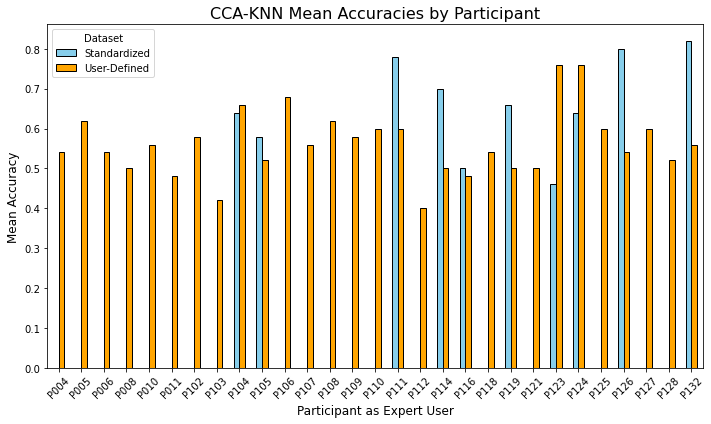

In [39]:
pivot_df = sorted_results_df.pivot(index="Participant", columns="Dataset", values="Mean Accuracy")

# Plot the bar chart
ax = pivot_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], edgecolor='black')

# Add labels and title
plt.title('CCA-KNN Mean Accuracies by Participant', fontsize=16)
plt.xlabel('Participant as Expert User', fontsize=12)
plt.ylabel('Mean Accuracy', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Dataset", fontsize=10)

# Adjust layout and display the chart
plt.tight_layout()
plt.savefig('cca_knn_accuracies.jpg', format='jpg')

In [58]:
from sklearn.linear_model import SGDClassifier

# Function to run CCA and SGD on each fold
def cca_sgd(data, expert_data, participant_column, target_column, k=5, n_components=2):
    """
    Perform CCA between expert user data and participants' data, then train an SGD Classifier on the CCA-transformed features.
    
    Parameters:
        data (DataFrame): The complete dataset including 'Participant' and 'feature' columns.
        expert_data (DataFrame): The expert user data.
        participant_column (str): The name of the participant column.
        target_column (str): The name of the target column.
        k (int): The number of folds for Group K-Fold cross-validation.
        n_components (int): Number of components for CCA.

    Returns:
        accuracies (list): A list of accuracy scores from each fold of the cross-validation.
    """
    group_kf = GroupKFold(n_splits=k)
    accuracies = []
    
    # Perform 80/20 train-test split using Group K-Fold cross-validation
    for train_index, test_index in group_kf.split(data, groups=data[participant_column]):
        train_ids = data[participant_column].iloc[train_index].unique()
        test_ids = data[participant_column].iloc[test_index].unique()
        
        train_data = data[data[participant_column].isin(train_ids)]
        test_data = data[data[participant_column].isin(test_ids)]
        
        # CCA between expert and training users
        X_train_cca = []
        y_train = []
        for pid in train_ids:
            pid_data = train_data[train_data[participant_column] == pid]
            X_pid_cca, y_pid = apply_cca_between_expert_and_others(expert_data, pid_data, target_column, n_components)
            X_train_cca.append(X_pid_cca)
            y_train.append(y_pid)

        # Combine all CCA-transformed training data
        X_train_cca = np.vstack(X_train_cca)
        y_train = np.concatenate(y_train)

        # CCA between expert and testing users
        X_test_cca = []
        y_test = []
        for pid in test_ids:
            pid_data = test_data[test_data[participant_column] == pid]
            X_pid_cca, y_pid = apply_cca_between_expert_and_others(expert_data, pid_data, target_column, n_components)
            X_test_cca.append(X_pid_cca)
            y_test.append(y_pid)

        # Combine all CCA-transformed testing data
        X_test_cca = np.vstack(X_test_cca)
        y_test = np.concatenate(y_test)

        # Initialize the SGD Classifier and fit to the CCA-transformed features
        sgd = SGDClassifier(loss="log", max_iter=1000, tol=1e-4)
        sgd.fit(X_train_cca, y_train)

        # Predict and evaluate using the test set
        y_pred = sgd.predict(X_test_cca)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    return accuracies



In [59]:
# Function to calculate and store results from CCA and SGD
def calculate_mean_accuracies_sgd(data, label, iterations=100):
    results = {}
    
    for i in range(iterations):
        expert_data, remaining_data = hold_out_expert(data, 'Participant')
        cca_sgd_accuracy = cca_sgd(remaining_data, expert_data, 'Participant', 'Gesture_Encoded', k=5, n_components=2)
        
        # Collect accuracies per participant
        participants = expert_data['Participant'].unique()
        for participant, accuracy in zip(participants, cca_sgd_accuracy):
            if participant not in results:
                results[participant] = []
            results[participant].append(accuracy)
    
    # Calculate mean accuracies
    mean_accuracies = {participant: np.mean(accuracies) for participant, accuracies in results.items()}
    
    # Convert to DataFrame
    results_df = pd.DataFrame.from_dict(mean_accuracies, orient='index', columns=['Mean Accuracy'])
    results_df.reset_index(inplace=True)
    results_df.rename(columns={'index': 'Participant'}, inplace=True)
    results_df['Dataset'] = label  # Standardized or User-Defined
    
    return results_df

# Run for both datasets
standardized_results_df = calculate_mean_accuracies_sgd(with_disability, 'Standardized', iterations=100)
userdef_results_df = calculate_mean_accuracies_sgd(userdef, 'User-Defined', iterations=100)

# Combine both results into a single DataFrame
combined_results_df = pd.concat([standardized_results_df, userdef_results_df], ignore_index=True)
sorted_results_df = combined_results_df.sort_values(by=['Dataset', 'Mean Accuracy'], ascending=[True, True])
# Print results
print(sorted_results_df)
sorted_results_df.to_csv('cca_sgd_accuracies.csv', index = False)


   Participant  Mean Accuracy       Dataset
4         P124       0.180000  Standardized
2         P119       0.190000  Standardized
5         P111       0.206250  Standardized
7         P126       0.207857  Standardized
8         P123       0.209000  Standardized
0         P132       0.220500  Standardized
9         P114       0.224444  Standardized
1         P105       0.225833  Standardized
6         P116       0.272000  Standardized
3         P104       0.282500  Standardized
13        P118       0.156667  User-Defined
25        P114       0.161667  User-Defined
27        P116       0.172500  User-Defined
17        P108       0.173333  User-Defined
22        P102       0.173333  User-Defined
30        P109       0.175714  User-Defined
18        P111       0.180000  User-Defined
36        P004       0.181667  User-Defined
33        P122       0.185000  User-Defined
19        P110       0.187778  User-Defined
29        P011       0.188889  User-Defined
26        P119       0.190000  U

In [61]:
sorted_results_df.to_csv('cca_sgd_accuracies.csv', index = False)


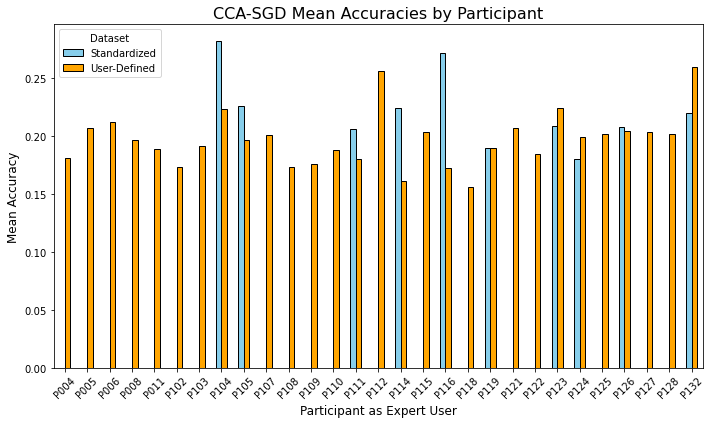

In [63]:
pivot_df = sorted_results_df.pivot(index="Participant", columns="Dataset", values="Mean Accuracy")

# Plot the bar chart
ax = pivot_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], edgecolor='black')

# Add labels and title
plt.title('CCA-SGD Mean Accuracies by Participant', fontsize=16)
plt.xlabel('Participant as Expert User', fontsize=12)
plt.ylabel('Mean Accuracy', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Dataset", fontsize=10)

# Adjust layout and display the chart
plt.tight_layout()
plt.savefig('cca_sgd_accuracies.jpg', format='jpg')

In [29]:
def run_pca_knn(df, n_components=8, n_neighbors=5, k=5):
    """
    Perform PCA on the 'feature' column and KNN classification using Group K-Fold validation.

    Parameters:
        df (DataFrame): Input DataFrame containing 'feature', 'Gesture_ID', and 'Participant' columns.
        n_components (int): Number of PCA components.
        n_neighbors (int): Number of neighbors for KNN.
        k (int): Number of folds for Group K-Fold cross-validation.

    Returns:
        explained_variance_ratios (list): Explained variance ratio for PCA in each fold.
        accuracies (list): Classification accuracies for KNN on test sets in each fold.
    """
    # Flatten 'feature' column
    df['feature_flat'] = df['feature'].apply(lambda x: np.ravel(x))

    # Extract features and labels
    X = np.vstack(df['feature_flat'].values)
    y = df['Gesture_ID']
    groups = df['Participant']

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Group K-Fold setup
    group_kf = GroupKFold(n_splits=k)
    accuracies = []
    explained_variance_ratios = []

    for train_index, test_index in group_kf.split(X_pca, y, groups=groups):
        # Split the data
        X_train, X_test = X_pca[train_index], X_pca[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train KNN
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        # Store explained variance ratio (same for all splits)
        explained_variance_ratios.append(pca.explained_variance_ratio_)

    return explained_variance_ratios, accuracies


stand_explained_variance_ratios, stand_accuracies = run_pca_knn(df=with_disability, n_components=10, n_neighbors=5, k=5)
#print("PCA Explained Variance Ratios:", explained_variance_ratios)
#print("KNN Classification Accuracies:", accuracies)

user_explained_variance_ratios, user_accuracies = run_pca_knn(df=userdef, n_components=10, n_neighbors=5, k=5)
#print("PCA Explained Variance Ratios:", explained_variance_ratios)
#print("KNN Classification Accuracies:", accuracies)


In [30]:
df_std = pd.DataFrame({
    "Dataset": "Standardized",
    "Fold": range(1, len(stand_accuracies) + 1),
    "Accuracy": stand_accuracies,
    "PCA Explained Variance Ratio": [list(ratios) for ratios in stand_explained_variance_ratios]
})

df_userdef = pd.DataFrame({
    "Dataset": "User-Defined",
    "Fold": range(1, len(user_accuracies) + 1),
    "Accuracy": user_accuracies,
    "PCA Explained Variance Ratio": [list(ratios) for ratios in user_explained_variance_ratios]
})

combined_df = pd.concat([df_std, df_userdef], ignore_index=True)

sorted_df = combined_df.sort_values(by=["Dataset", "Fold"])

print(sorted_df)

sorted_df.to_csv("pca_knn_results.csv", index=False)

        Dataset  Fold  Accuracy  \
0  Standardized     1  0.460000   
1  Standardized     2  0.400000   
2  Standardized     3  0.490000   
3  Standardized     4  0.530000   
4  Standardized     5  0.340000   
5  User-Defined     1  0.140000   
6  User-Defined     2  0.163333   
7  User-Defined     3  0.100000   
8  User-Defined     4  0.163333   
9  User-Defined     5  0.150000   

                        PCA Explained Variance Ratio  
0  [0.3084577767155306, 0.13776651646482144, 0.10...  
1  [0.3084577767155306, 0.13776651646482144, 0.10...  
2  [0.3084577767155306, 0.13776651646482144, 0.10...  
3  [0.3084577767155306, 0.13776651646482144, 0.10...  
4  [0.3084577767155306, 0.13776651646482144, 0.10...  
5  [0.2821324426375423, 0.14262123464746596, 0.08...  
6  [0.2821324426375423, 0.14262123464746596, 0.08...  
7  [0.2821324426375423, 0.14262123464746596, 0.08...  
8  [0.2821324426375423, 0.14262123464746596, 0.08...  
9  [0.2821324426375423, 0.14262123464746596, 0.08...  


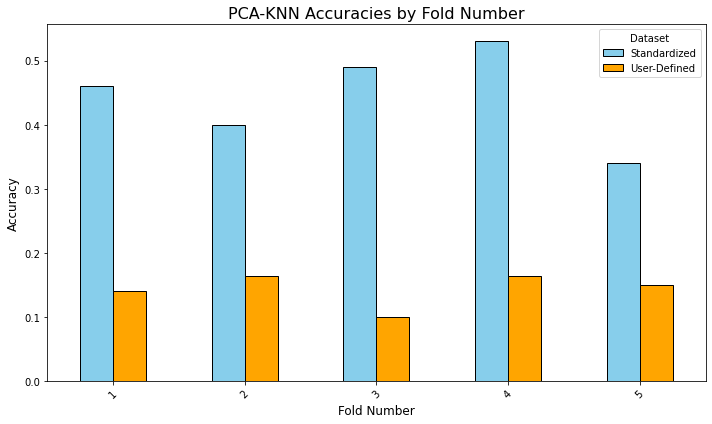

In [41]:
pivot_df = sorted_df.pivot(index="Fold", columns="Dataset", values="Accuracy")

# Plot the bar chart
ax = pivot_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], edgecolor='black')

# Add labels and title
plt.title('PCA-KNN Accuracies by Fold Number', fontsize=16)
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Dataset", fontsize=10)

# Adjust layout and display the chart
plt.tight_layout()
plt.savefig('pca_knn_accuracies.jpg', format='jpg')

In [31]:
def run_knn_baseline_with_group_kfold(data, expert_data, remaining_data, target_column, n_neighbors=5, k=5):
    """
    Perform KNN classification with Group K-Fold cross-validation using a combination of expert and remaining data.

    Parameters:
        data (DataFrame): Full dataset for reference (includes 'Participant' column for grouping).
        expert_data (DataFrame): Expert user data.
        remaining_data (DataFrame): Remaining participant data.
        target_column (str): Column name for the target labels.
        n_neighbors (int): Number of neighbors for KNN.
        k (int): Number of folds for Group K-Fold cross-validation.

    Returns:
        accuracies (list): List of classification accuracies for each fold.
    """
    # Flatten the features from both datasets
    X_expert = flatten_features(expert_data['feature'])
    X_remaining = flatten_features(remaining_data['feature'])
    
    # Combine the feature sets and their corresponding targets
    X_combined = np.vstack((X_expert, X_remaining))
    y_expert = expert_data[target_column].values
    y_remaining = remaining_data[target_column].values
    y_combined = np.concatenate((y_expert, y_remaining))

    # Combine participant IDs
    participant_ids_expert = expert_data['Participant'].values
    participant_ids_remaining = remaining_data['Participant'].values
    participant_ids_combined = np.concatenate((participant_ids_expert, participant_ids_remaining))
    
    # Group K-Fold setup
    group_kf = GroupKFold(n_splits=k)
    accuracies = []

    for train_index, test_index in group_kf.split(X_combined, y_combined, groups=participant_ids_combined):
        # Split the data
        X_train, X_test = X_combined[train_index], X_combined[test_index]
        y_train, y_test = y_combined[train_index], y_combined[test_index]

        # Train KNN
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
    return accuracies



In [34]:
# Run baseline KNN with Group K-Fold for each dataset
standardized_expert_data, standardized_remaining_data = hold_out_expert(with_disability, 'Participant')
standardized_accuracies = run_knn_baseline_with_group_kfold(
    data=with_disability,
    expert_data=standardized_expert_data,
    remaining_data=standardized_remaining_data,
    target_column='Gesture_Encoded',
    n_neighbors=5,
    k=5
)

userdef_expert_data, userdef_remaining_data = hold_out_expert(userdef, 'Participant')
userdef_accuracies = run_knn_baseline_with_group_kfold(
    data=userdef,
    expert_data=userdef_expert_data,
    remaining_data=userdef_remaining_data,
    target_column='Gesture_Encoded',
    n_neighbors=5,
    k=5
)

# Combine results into a DataFrame
results_df = pd.DataFrame({
    "Dataset": ["Standardized"] * len(standardized_accuracies) + ["User-Defined"] * len(userdef_accuracies),
    "Fold": list(range(1, len(standardized_accuracies) + 1)) + list(range(1, len(userdef_accuracies) + 1)),
    "Accuracy": standardized_accuracies + userdef_accuracies
})

# Calculate mean accuracies for each dataset
mean_accuracies = results_df.groupby("Dataset")["Accuracy"].mean().reset_index()
mean_accuracies.columns = ["Dataset", "Mean Accuracy"]

# Display results
print("Fold-wise accuracies:")
print(results_df)

print("\nMean accuracies:")
print(mean_accuracies)

# Save to CSV
results_df.to_csv("knn_baseline_group_kfold_results.csv", index=False)
mean_accuracies.to_csv("knn_baseline_mean_accuracies.csv", index=False)


Fold-wise accuracies:
        Dataset  Fold  Accuracy
0  Standardized     1  0.390000
1  Standardized     2  0.410000
2  Standardized     3  0.420000
3  Standardized     4  0.540000
4  Standardized     5  0.320000
5  User-Defined     1  0.120000
6  User-Defined     2  0.133333
7  User-Defined     3  0.123333
8  User-Defined     4  0.176667
9  User-Defined     5  0.206667

Mean accuracies:
        Dataset  Mean Accuracy
0  Standardized          0.416
1  User-Defined          0.152


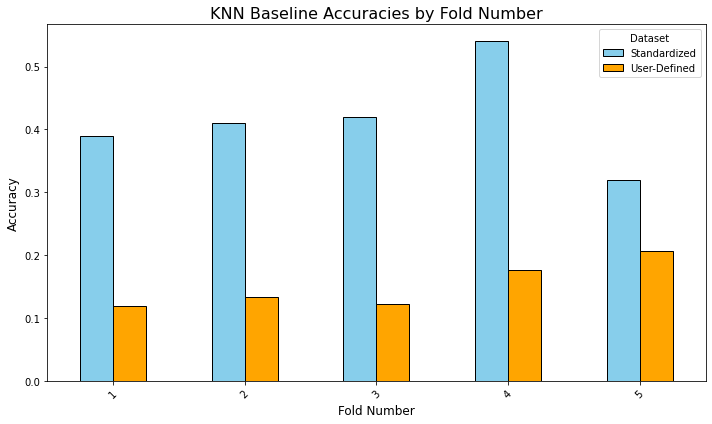

In [43]:
pivot_df = results_df.pivot(index="Fold", columns="Dataset", values="Accuracy")

# Plot the bar chart
ax = pivot_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], edgecolor='black')

# Add labels and title
plt.title('KNN Baseline Accuracies by Fold Number', fontsize=16)
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Dataset", fontsize=10)

# Adjust layout and display the chart
plt.tight_layout()
plt.savefig('knn_baseline_accuracies.jpg', format='jpg')

## NOT USING BELOW

In [30]:
#11/11 without k-fold
def apply_cca_and_knn(data, expert_data, participant_column, target_column, test_size=0.2, n_neighbors=5, n_components=2):
    # Split the remaining data into train and test sets using the provided function
    train_data, test_data = split_train_test(data, participant_column, test_size=test_size)
    #print("train data shape", train_data.shape)
    #print("test data shape", test_data.shape)

    
    # Apply CCA individually for each training user with the expert
    X_train_cca = []
    y_train = []
    for pid in train_data[participant_column].unique():
        pid_data = train_data[train_data[participant_column] == pid]
        # Individual CCA model and transformation for each training participant
        X_pid_cca, y_pid = apply_cca_between_expert_and_others(expert_data, pid_data, target_column, n_components)
        X_train_cca.append(X_pid_cca)
        y_train.append(y_pid)
    
    # Combine all CCA-transformed training data
    X_train_cca = np.vstack(X_train_cca)  # Combining individual transformations
    y_train = np.concatenate(y_train)
    
    # Apply CCA individually for each testing user with the expert
    X_test_cca = []
    y_test = []
    for pid in test_data[participant_column].unique():
        pid_data = test_data[test_data[participant_column] == pid]
        # Individual CCA model and transformation for each testing participant
        X_pid_cca, y_pid = apply_cca_between_expert_and_others(expert_data, pid_data, target_column, n_components)
        X_test_cca.append(X_pid_cca)
        y_test.append(y_pid)
    
    # Combine all CCA-transformed testing data
    X_test_cca = np.vstack(X_test_cca)  # Combining individual transformations
    y_test = np.concatenate(y_test)
    
    # Run KNN on CCA-transformed feature sets
    accuracy = run_knn(X_train_cca, y_train, X_test_cca, y_test, n_neighbors)
    
    return accuracy
#expert_data, remaining_data = hold_out_expert(with_disability, 'Participant')
#In CCA, the number of components must be less than or equal to the number of features in either dataset or the number of samples minus one, whichever is smaller.
#so changed n_components to 1
#cca_knn_accuracy=apply_cca_and_knn(remaining_data, expert_data, 'Participant', 'Gesture_Encoded')
#

In [37]:
#running cca with no k-fold and averaging for 100 runs
standard_nokfold = {}  # Dictionary to store accuracies per participant

for i in range(100):
    expert_data, remaining_data = hold_out_expert(with_disability, 'Participant')

    
    # Apply CCA and KNN, assuming 'apply_cca_and_knn' returns accuracy for this iteration
    accuracy = apply_cca_and_knn(remaining_data, expert_data, 'Participant', 'Gesture_Encoded', n_components=1)
    
    # Add the accuracy to the corresponding participant's list
    for pid in expert_data['Participant'].unique():
        if pid not in standard_nokfold:
            standard_nokfold[pid] = []
            standard_nokfold[pid].append(accuracy)

# Calculate the mean accuracy for each participant across all iterations
mean_accuracies_per_participant = {pid: np.mean(accs) for pid, accs in standard_nokfold.items()}

print(" No KNN Standardized Mean accuracies per participant:", mean_accuracies_per_participant)




userdef_nokfold = {}
for i in range(100):
    expert_data, remaining_data = hold_out_expert(userdef, 'Participant')
#train_data, test_data = split_train_test(remaining_data, 'Participant', test_size=0.2)
#In CCA, the number of components must be less than or equal to the number of features in either dataset or the number of samples minus one, whichever is smaller.
#so changed n_components to 1
    accuracy=apply_cca_and_knn(remaining_data, expert_data, 'Participant', 'Gesture_Encoded', n_neighbors=5, n_components=2)
    #get mean accuracy for each expert_id
    for pid in expert_data['Participant'].unique():
        if pid not in userdef_nokfold:
            userdef_nokfold[pid] = []
            userdef_nokfold[pid].append(accuracy)

mean_accuracies_per_participant = {pid: np.mean(accs) for pid, accs in userdef_nokfold.items()}

print("No KNN User-Def Mean accuracies per participant:", mean_accuracies_per_participant)

#Lower accuracy without k-fold

 No KNN Standardized Mean accuracies per participant: {'P114': 0.15, 'P123': 0.23, 'P111': 0.11, 'P105': 0.31, 'P119': 0.18, 'P116': 0.15, 'P124': 0.25, 'P132': 0.28, 'P126': 0.17, 'P104': 0.18}
No KNN User-Def Mean accuracies per participant: {'P107': 0.15666666666666668, 'P102': 0.18666666666666668, 'P122': 0.22, 'P008': 0.16333333333333333, 'P128': 0.21, 'P121': 0.16, 'P132': 0.17666666666666667, 'P010': 0.19666666666666666, 'P109': 0.12333333333333334, 'P110': 0.21, 'P112': 0.23666666666666666, 'P011': 0.19666666666666666, 'P115': 0.20333333333333334, 'P105': 0.22333333333333333, 'P116': 0.21333333333333335, 'P005': 0.17, 'P123': 0.18666666666666668, 'P006': 0.22666666666666666, 'P127': 0.24, 'P125': 0.17333333333333334, 'P108': 0.21333333333333335, 'P111': 0.24, 'P004': 0.16666666666666666, 'P103': 0.20333333333333334, 'P104': 0.25666666666666665, 'P118': 0.22666666666666666, 'P114': 0.23, 'P124': 0.18333333333333332, 'P106': 0.15333333333333332, 'P119': 0.19666666666666666}


In [41]:
#see the shapes of all pid and expert_data for fitting
def k_fold_cross_validation(data, expert_data, participant_column, target_column, k=5, n_neighbors=5, n_components=2):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(data[participant_column].unique()):
        train_ids = data[participant_column].unique()[train_index]
        test_ids = data[participant_column].unique()[test_index]
        print(train_ids.shape)
        print(test_ids.shape)

        train_data = data[data[participant_column].isin(train_ids)]
        test_data = data[data[participant_column].isin(test_ids)]
        diff_shape = []

        for pid in train_ids:
            pid_data = train_data[train_data[participant_column] == pid]
            if expert_data.shape != pid_data.shape:
                diff_shape.append(pid)
    return diff_shape
k_fold_cross_validation(remaining_data, expert_data, 'Participant', 'Gesture_Encoded', k=5, n_neighbors=5, n_components=1)

#shape problem with 'P104', 'P111', 'P114', 'P116', 'P119', 'P123', 'P126', 'P131', 'P132'

(12,)
(4,)
(13,)
(3,)
(13,)
(3,)
(13,)
(3,)
(13,)
(3,)


['P104', 'P111', 'P114', 'P116', 'P119', 'P123', 'P126', 'P131', 'P132']

In [38]:
np.mean(cca_knn_accuracy) #accuracy for each k-fold.... really poor (maybe because n_components is 1??)

0.644

In [42]:
#### don't use
# Hold out one participant as the expert
def hold_out_expert(data, participant_column):
    participant_ids = data[participant_column].unique()
    expert_user = np.random.choice(participant_ids)  # Randomly select one participant as expert
    data_expert = data[data[participant_column] == expert_user]  # Expert data
    data_remaining = data[data[participant_column] != expert_user]  # Remaining data
    return data_expert, data_remaining

def apply_cca_between_expert_and_others(expert_data, participant_data, target_column, n_components):
    """
    Apply CCA between expert data and a participant's data.
    
    Parameters:
        expert_data (DataFrame): Expert user data.
        participant_data (DataFrame): Participant data.
        target_column (str): Name of the target column.
        n_components (int): Number of CCA components.
    
    Returns:
        X_cca (array): CCA-transformed features for the participant data.
        y (array): Target values for the participant data.
    """
    # Extract features and target
    X_expert = np.vstack(expert_data['feature'].apply(lambda x: np.ravel(x)).values)
    X_participant = np.vstack(participant_data['feature'].apply(lambda x: np.ravel(x)).values)
    y = participant_data[target_column].values

    # Encode target labels for CCA
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y).reshape(-1, 1)

    # Apply CCA
    cca = CCA(n_components=n_components)
    X_cca, _ = cca.fit_transform(X_participant, y_encoded)

    return X_cca, y

def run_knn(X_train, y_train, X_test, y_test, n_neighbors):
    """
    Run KNN classification on the transformed data and return the accuracy.
    
    Parameters:
        X_train (array): CCA-transformed training features.
        y_train (array): Training labels.
        X_test (array): CCA-transformed test features.
        y_test (array): Test labels.
        n_neighbors (int): Number of neighbors for KNN.
    
    Returns:
        accuracy (float): Classification accuracy of KNN.
    """
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return accuracy_score(y_test, y_pred)

def k_fold_cross_validation(data, expert_data, participant_column, target_column, k=5, n_neighbors=5, n_components=2):
    """
    Perform k-fold cross-validation using CCA between expert user data and participants,
    and KNN classification on the transformed data.
    
    Parameters:
        data (DataFrame): Input DataFrame containing participants' data.
        expert_data (DataFrame): Expert user data for CCA.
        participant_column (str): Name of the participant column.
        target_column (str): Name of the target column.
        k (int): Number of folds for cross-validation.
        n_neighbors (int): Number of neighbors for KNN.
        n_components (int): Number of CCA components.
    
    Returns:
        accuracies (list): List of accuracies for each fold.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []
    
    # k-fold cross-validation
    for train_index, test_index in kf.split(data[participant_column].unique()):
        train_ids = data[participant_column].unique()[train_index]
        test_ids = data[participant_column].unique()[test_index]
        
        train_data = data[data[participant_column].isin(train_ids)]
        test_data = data[data[participant_column].isin(test_ids)]
        
        # Apply CCA between expert and training participants
        X_train_cca = []
        y_train = []
        for pid in train_ids:
            pid_data = train_data[train_data[participant_column] == pid]
            X_pid_cca, y_pid = apply_cca_between_expert_and_others(expert_data, pid_data, target_column, n_components)
            X_train_cca.append(X_pid_cca)
            y_train.append(y_pid)
        
        # Combine CCA-transformed training data
        X_train_cca = np.vstack(X_train_cca)
        y_train = np.concatenate(y_train)
        
        # Apply CCA between expert and testing participants
        X_test_cca = []
        y_test = []
        for pid in test_ids:
            pid_data = test_data[test_data[participant_column] == pid]
            X_pid_cca, y_pid = apply_cca_between_expert_and_others(expert_data, pid_data, target_column, n_components)
            X_test_cca.append(X_pid_cca)
            y_test.append(y_pid)
        
        # Combine CCA-transformed testing data
        X_test_cca = np.vstack(X_test_cca)
        y_test = np.concatenate(y_test)
        
        # Run KNN on CCA-transformed data
        accuracy = run_knn(X_train_cca, y_train, X_test_cca, y_test, n_neighbors)
        accuracies.append(accuracy)
    
    return accuracies
expert_data, remaining_data = hold_out_expert(result, 'Participant')
accuracies = k_fold_cross_validation(remaining_data, expert_data, 'Participant', 'Gesture_ID', k=5, n_neighbors=10, n_components=1)
print("Cross-validation accuracies:", accuracies)
print("Average accuracy:", np.mean(accuracies))

Cross-validation accuracies: [0.3433962264150943, 0.4666666666666667, 0.38, 0.255, 0.31]
Average accuracy: 0.3510125786163522


In [44]:
#solution with resampling -- didn't use for final run through
from sklearn.cross_decomposition import CCA
from sklearn.utils import resample

def apply_cca_between_expert_and_others(expert_data, other_data, target_column, n_components=2):
    # Separate features (X) and target (y)
    X_expert = flatten_features(expert_data['feature'])
    X_other = flatten_features(other_data['feature'])

    y_expert = expert_data[target_column]
    y_other = other_data[target_column]
    
    # Match the sample size between X_expert and X_other
    X_other_resampled, y_other_resampled = resample(X_other, y_other, n_samples=X_expert.shape[0], random_state=42)
    
    # Apply CCA between expert and other participant
    cca = CCA(n_components=n_components)
    cca.fit(X_expert, X_other_resampled)
    X_other_cca = cca.transform(X_other_resampled)
    
    return X_other_cca, y_other_resampled#, X_expert, X_other_resampled




In [ ]:
#need to relabel freq_data to time data. and turn that to np.fft.fft to convert to time

# Parseval's theorem verification function
def parsevals_theorem_verification(df_freq):
    time_domain_data = {}
    freq_domain_squares_sum = {}
    time_domain_squares_sum = {}

    for sensor in df_freq.columns:
        # Extract the time domain data for the sensor (column of the dataframe)
        time_data = df_freq[sensor].values
        
        # FFT to transform to freq domain
        freq_data = np.fft.fft(time_data)
        
        # Parseval's theorem: Sum of squares in the frequency domain
        freq_domain_sum_sq = np.sum(np.abs(freq_data)**2)
        
        # Parseval's theorem: Sum of squares in the time domain
        time_domain_sum_sq = np.sum(np.abs(time_data)**2)
        
        # Store results in dictionaries
        time_domain_data[sensor] = time_data
        freq_domain_squares_sum[sensor] = freq_domain_sum_sq
        time_domain_squares_sum[sensor] = time_domain_sum_sq
        
        # Output verification for this sensor
        print(f'Sensor: {sensor}')
        print(f'Sum of squares (Frequency domain): {freq_domain_sum_sq}')
        print(f'Sum of squares (Time domain): {time_domain_sum_sq}')
        print(f'Parseval\'s theorem holds: {np.isclose(freq_domain_sum_sq, time_domain_sum_sq)}\n')
    
    return pd.DataFrame(time_domain_data), freq_domain_squares_sum, time_domain_squares_sum

# Assuming df_freq is your dataframe with frequency domain EMG data
# df_time, freq_squares, time_squares = parsevals_theorem_verification(df_freq)


#want to see that freq_domain_sum_sq is the same as time_domain_sum_sq
#can try and generalize by gesture trial as opposed to by column
#load in metadata and break up huge dataframe by each gesture chunk

In [ ]:
parsevals_theorem_verification(EMG_sliced)

In [ ]:
###NOT USING
#RAN INTO ISSUE WITH TAKING SECOND LOG OF NEG VALUES SINCE LOG(ZERO/DOT) GAVE NEG VALUES
# either follow code in cell below to take maximum or maybe do abs value of log(zero/dot)?? these are both diff from original formula though
def third_order_moment_log(df_freq, second_order_moments_raw, first_order_moments_raw, zero_order_moments_raw):
    # Step 1: Compute the square roots
    sqrt_first_diff = np.sqrt(zero_order_moments_raw - first_order_moments_raw)
    sqrt_second_diff = np.sqrt(zero_order_moments_raw - second_order_moments_raw)
    #print(sqrt_first_diff)
    #print(sqrt_second_diff)
    
    # Step 2: Perform the dot product
    dot_product = np.dot(sqrt_first_diff, sqrt_second_diff)
    #print(dot_product)
    # Step 3: Compute the sparseness formula
    sparseness = np.log(np.abs(zero_order_moments_raw / dot_product))
    print(zero_order_moments_raw)
    print(dot_product)
    
    print(sparseness)
    
    # Step 4: Apply the logarithm again for third-order moments
    third_order_moments_log = np.log(sparseness)
    
    return third_order_moments_log
third_order_moments_log = third_order_moment_log(EMG_sliced, second_order_moments_raw, first_order_moments_raw, zero_order_moments_raw)

In [ ]:
###NOT USING
def freq_second_order_moment_log(df_freq, zero_order_moments_raw):
    second_order_moments_log = []
    second_order_moments_raw = []

    for i, sensor in enumerate(df_freq.columns):
        # Extract the frequency domain data for the sensor (column of the dataframe)
        time_data = df_freq[sensor].values
        freq_data = np.fft.fft(time_data)
        
        # Step 1: Take first derivative
        first_deriv = np.gradient(freq_data)
        
        #Step 2: take second derivative
        second_deriv = np.gradient(first_deriv)
        
        # Step 3: Square the signal (power) at each frequency of the first deriv
        signal_squared = np.abs(second_deriv) ** 2
        
        # Step 4: Integrate (sum) the squared values to get the total power
        total_power = np.sum(signal_squared)
        
        # Step 4: Take the logarithm of the total power
        log_total_power = np.log(total_power/(zero_order_moments_raw[i]**4))
        
        # Store the result in the dictionary
        second_order_moments_log.append(log_total_power)
        second_order_moments_raw.append(total_power)

    
    return second_order_moments_log, second_order_moments_raw

freq_second_order_moments_log, second_order_moments_raw = freq_first_order_moment_log(EMG_sliced, zero_order_moments_raw)
#output = zero_order_moments_log is the zeroeth feature

In [ ]:
###NOT USING
def freq_first_order_moment_log(df_freq, freq_zero_order_moments_raw):
    # Initialize lists to store the results for each sensor
    first_order_moments_log = []
    first_order_moments_raw = []
    
    for i,sensor in enumerate(df_freq.columns):
        # Extract the frequency domain data for the sensor (column of the dataframe)
        time_data = df_freq[sensor].values
        freq_data = np.fft.fft(time_data)
        
        # Step 1: Take first derivative
        first_deriv = np.gradient(freq_data)
        
        # Step 2: Square the signal (power) at each frequency of the first deriv
        signal_squared = np.abs(first_deriv) ** 2
        
        # Step 3: Integrate (sum) the squared values to get the total power
        total_power = np.sum(signal_squared)
        
        # Step 4: Take the logarithm of the total power
        log_total_power = np.log(total_power / (zero_order_moments_raw[i]**2))
        
        # Store the results in the lists
        first_order_moments_log.append(log_total_power)
        first_order_moments_raw.append(total_power)

    # Convert lists to numpy arrays for consistency
    first_order_moments_log = np.array(first_order_moments_log)
    first_order_moments_raw = np.array(first_order_moments_raw)
    
    return first_order_moments_log, first_order_moments_raw

freq_first_order_moments_log, freq_first_order_moments_raw = freq_first_order_moment_log(EMG_sliced, freq_zero_order_moments_raw)

In [ ]:
###NOT USING
def freq_zero_order_moment_log(df_freq):
    zero_order_moments_log = []
    zero_order_moments_raw = []

    for sensor in df_freq.columns:
        # Extract the frequency domain data for the sensor (column of the dataframe)
        time_data = df_freq[sensor].values
        freq_data = np.fft.fft(time_data)

        
        # Step 1: Square the signal (power) at each frequency
        signal_squared = np.abs(freq_data) ** 2
        
        # Step 2: Integrate (sum) the squared values to get the total power
        total_power = np.sum(signal_squared)
        
        # Step 3: Take the logarithm of the total power
        log_total_power = np.log(total_power)
        
        # Store the result in the dictionary
        zero_order_moments_log.append(log_total_power)
        zero_order_moments_raw.append(total_power)
        
        #convert to np.array for consistency
    
    return zero_order_moments_log, zero_order_moments_raw

freq_zero_order_moments_log, freq_zero_order_moments_raw = freq_zero_order_moment_log(EMG_sliced)
#output = zero_order_moments_log is the zeroeth feature

In [ ]:
#to do fft: need to slice out EMG data and only use that
EMG_sliced = EMG_stand.iloc[:,3:]
EMG_sliced